In [76]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
from functools import reduce

from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from statsmodels.stats.outliers_influence import variance_inflation_factor

import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline
warnings.filterwarnings("ignore")

# imports
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import os

from timeit import default_timer

In [2]:
# insert API key here
API_KEY = '1vXKptlEX84OoMidufyRXLtNDSg'

In [4]:
urls = ['https://api.glassnode.com/v1/metrics/addresses/count',
'https://api.glassnode.com/v1/metrics/addresses/sending_count',
'https://api.glassnode.com/v1/metrics/addresses/receiving_count',
'https://api.glassnode.com/v1/metrics/addresses/active_count',
'https://api.glassnode.com/v1/metrics/addresses/new_non_zero_count',
'https://api.glassnode.com/v1/metrics/blockchain/block_height',
'https://api.glassnode.com/v1/metrics/indicators/sopr',
'https://api.glassnode.com/v1/metrics/market/price_usd_close',
'https://api.glassnode.com/v1/metrics/market/marketcap_usd',
'https://api.glassnode.com/v1/metrics/mining/difficulty_latest',
'https://api.glassnode.com/v1/metrics/mining/hash_rate_mean']

In [5]:
len(urls)

11

In [47]:
data = []
for url in urls:
  label = url.split('/')[-1]
      
  # make API request
  res = requests.get(url, params={'a': 'ETH'
                                  ,'api_key': API_KEY})
  # convert to pandas dataframe
  df = pd.read_json(res.text, convert_dates=['t'])
  df.set_index('t', inplace = True)
  df.rename(columns={'v':label}, inplace=True)
  data.append(df)


In [1]:
## Inspecting one dataframe from list of results
data[7]

NameError: name 'data' is not defined

In [54]:
# Creating a dataframe from the list of results generated from the API
data_df = pd.concat(data, axis=1)
data_df

,count,sending_count,receiving_count,active_count,new_non_zero_count,block_height,sopr,price_usd_close,marketcap_usd,difficulty_latest,hash_rate_mean
t,,,,,,,,,,,
2015-07-30,9203.0,0.0,0.0,0.0,9203.0,6911.0,NaN,NaN,NaN,3.382792e+11,1.910758e+10
2015-07-31,9359.0,0.0,0.0,0.0,156.0,13774.0,NaN,NaN,NaN,8.231927e+11,4.679999e+10
2015-08-01,9474.0,0.0,0.0,0.0,115.0,19067.0,NaN,NaN,NaN,9.566506e+11,5.421432e+10
2015-08-02,9561.0,0.0,0.0,0.0,87.0,24425.0,NaN,NaN,NaN,1.102546e+12,6.315518e+10
2015-08-03,9637.0,0.0,0.0,0.0,76.0,29705.0,NaN,NaN,NaN,1.154732e+12,6.876058e+10
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-28,126565723.0,218007.0,270534.0,458169.0,82525.0,13117022.0,1.045690,3243.091440,3.805415e+11,8.349154e+15,6.130445e+14
2021-08-29,126646738.0,216340.0,261453.0,443638.0,81015.0,13123511.0,1.038184,3232.684457,3.771270e+11,8.344136e+15,6.156244e+14
2021-08-30,126736492.0,216528.0,279101.0,463898.0,89754.0,13129983.0,1.054713,3236.705129,3.779495e+11,8.363391e+15,6.243794e+14


In [63]:
## Generating list of columns with more than 1 missing value
test_list = list(data_df.isna().sum()[data_df.isna().sum() > 1].index)
test_list

['sopr', 'price_usd_close', 'marketcap_usd']

In [66]:
## Looping through list and comparing index values
for i in test_list:
    display(data_df[data_df[i].isna()].index)

DatetimeIndex(['2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02',
               '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2021-09-01'],
              dtype='datetime64[ns]', name='t', freq=None)

DatetimeIndex(['2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02',
               '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2015-08-07', '2018-04-12', '2018-04-13', '2018-04-14',
               '2018-04-15'],
              dtype='datetime64[ns]', name='t', freq=None)

DatetimeIndex(['2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02',
               '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2015-08-07', '2021-09-01'],
              dtype='datetime64[ns]', name='t', freq=None)

In [118]:
data_df = data_df.dropna(axis=0)#.isna().sum()

In [1]:
data_df.to_excel('data/eth_api_data.xlsx')

NameError: name 'data_df' is not defined

In [119]:
# Creating a matrix of correlations for each of the features in the dataframe
corr_matrix = data_df.corr()

# Creating a boolean mask for all values on or above the matrix diagonal
corr_matrix_mask = np.triu(np.ones_like(data_df.corr(), dtype=bool));

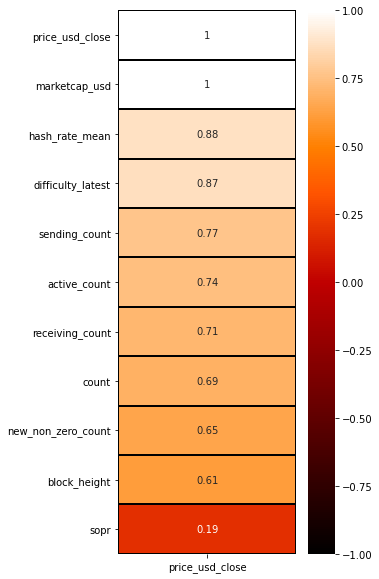

In [120]:
# Quickly looking at how each feature correlates to price
plt.figure(figsize=(4,10))
heatmap = sns.heatmap(data_df.corr()[['price_usd_close']].sort_values(by='price_usd_close', ascending=False), vmin=-1, vmax=1, linewidths=1, linecolor='black', annot=True, fmt='.2g', cmap="gist_heat")

In [1]:
x = data_df.drop('price_usd_close', axis=1)
y = data_df.price_usd_close
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15, 15))
fig.set_tight_layout(True)
for index, col in enumerate(x.columns): 
    ax = axes[index//2][index%3]
    ax.scatter(x[col], y, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("Price");

NameError: name 'data_df' is not defined

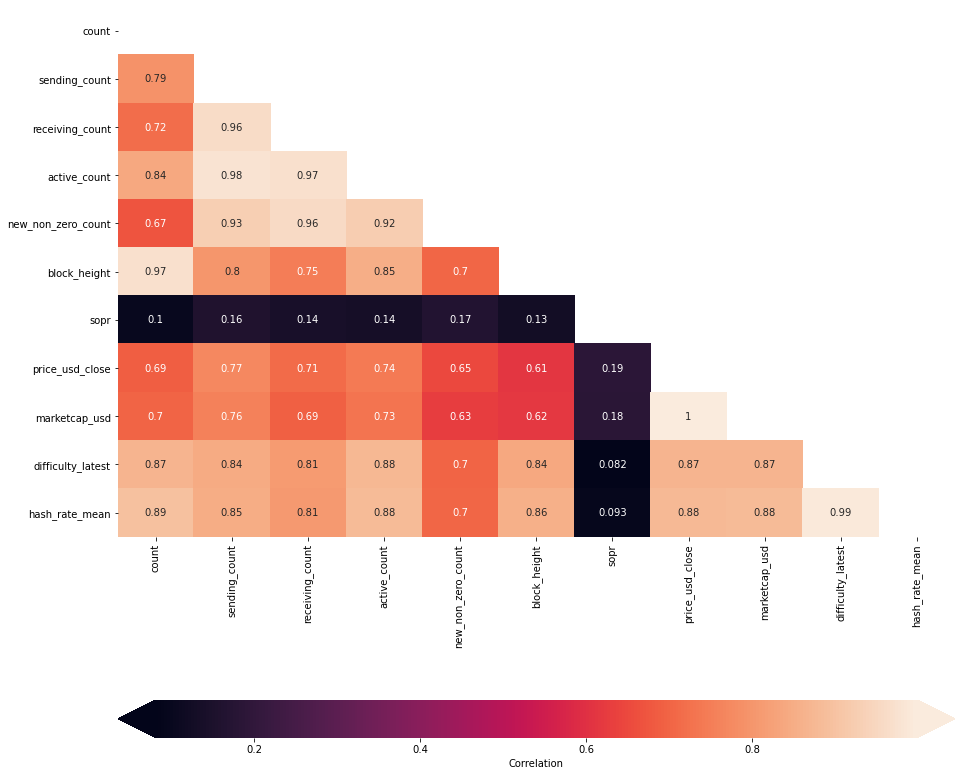

In [122]:
# Creating a heatmap of correlation coefficients
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(
            corr_matrix,
            ax=ax,
            annot=True,
            mask=corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

In [123]:
data_df.columns

Index(['count', 'sending_count', 'receiving_count', 'active_count',
       'new_non_zero_count', 'block_height', 'sopr', 'price_usd_close',
       'marketcap_usd', 'difficulty_latest', 'hash_rate_mean'],
      dtype='object')

In [124]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2212 entries, 2015-08-08 to 2021-08-31
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               2212 non-null   float64
 1   sending_count       2212 non-null   float64
 2   receiving_count     2212 non-null   float64
 3   active_count        2212 non-null   float64
 4   new_non_zero_count  2212 non-null   float64
 5   block_height        2212 non-null   float64
 6   sopr                2212 non-null   float64
 7   price_usd_close     2212 non-null   float64
 8   marketcap_usd       2212 non-null   float64
 9   difficulty_latest   2212 non-null   float64
 10  hash_rate_mean      2212 non-null   float64
dtypes: float64(11)
memory usage: 207.4 KB


In [125]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(data_df)
print(scaled_df)

[[0.00000000e+00 2.81804450e-04 0.00000000e+00 ... 1.16445076e-04
  0.00000000e+00 0.00000000e+00]
 [1.99492123e-06 0.00000000e+00 8.40115869e-05 ... 4.51751572e-05
  1.61012428e-05 7.86519370e-06]
 [7.11232786e-06 7.82289154e-04 5.20871839e-04 ... 3.22921122e-05
  4.06845886e-05 2.41552293e-05]
 ...
 [9.98533749e-01 4.86694321e-01 4.38564007e-01 ... 7.73113085e-01
  9.92185234e-01 9.78608732e-01]
 [9.99241465e-01 4.87118155e-01 4.68216736e-01 ... 7.74799264e-01
  9.94475327e-01 9.92528030e-01]
 [1.00000000e+00 5.22591699e-01 4.93892358e-01 ... 8.03292784e-01
  1.00000000e+00 1.00000000e+00]]


In [126]:
# Dropping the dependent variable from the independent columns
X = data_df.drop(['price_usd_close'], axis=1)

# Setting our dependent variable as price
y = data_df['price_usd_close']

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

# Predict price with the trained model
pred_lr1 = lr.predict(X_test)

# Get the coefficient of determination for training and test data
train_score_lr1 = lr.score(X_train, y_train)
test_score_lr1 = lr.score(X_test, y_test)

In [130]:
# Take a peek at model coef
lr.coef_[0]

-1.3737199078422222e-06

In [131]:
# Baseline price without features
lr.intercept_

-4.613200362773171

In [132]:
# Find the error of our predicted y test values
rmse_lr1 = mean_squared_error(y_test, pred_lr1, squared=False)

In [133]:
train_score_lr1, test_score_lr1, rmse_lr1

(0.9980381884746654, 0.9981279962887825, 28.379635063576305)

In [134]:
# Cross validate our model and find the mean of the training scores
scores_simple_1 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

In [135]:
simple_1_mean = np.mean(scores_simple_1['train_score'])
simple_1_mean_test = np.mean(scores_simple_1['test_score'])

In [136]:
from scipy import stats

import statsmodels.api as sm


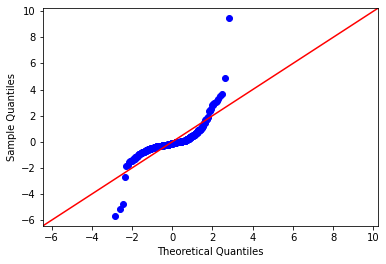

In [137]:
# Checking the QQ Plot to understand the distribution of residuals
residuals1 = (y_test - pred_lr1)
sm.graphics.qqplot(residuals1, dist=stats.norm, line="45", fit=True);

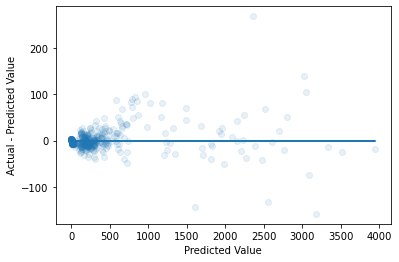

In [138]:
# Checking for homoscedasticity 

residuals1 = (y_test - pred_lr1)
fig, ax = plt.subplots()
ax.scatter(pred_lr1, residuals1, alpha=.1)
ax.plot(pred_lr1, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

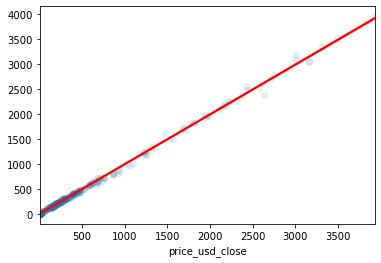

In [139]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_lr1, data = df, line_kws={'color':'r'}, scatter_kws={'alpha':0.1});

#### Model 2 Using MinMaxScaler

In [140]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(data_df)
print(scaled_df)

[[0.00000000e+00 2.81804450e-04 0.00000000e+00 ... 1.16445076e-04
  0.00000000e+00 0.00000000e+00]
 [1.99492123e-06 0.00000000e+00 8.40115869e-05 ... 4.51751572e-05
  1.61012428e-05 7.86519370e-06]
 [7.11232786e-06 7.82289154e-04 5.20871839e-04 ... 3.22921122e-05
  4.06845886e-05 2.41552293e-05]
 ...
 [9.98533749e-01 4.86694321e-01 4.38564007e-01 ... 7.73113085e-01
  9.92185234e-01 9.78608732e-01]
 [9.99241465e-01 4.87118155e-01 4.68216736e-01 ... 7.74799264e-01
  9.94475327e-01 9.92528030e-01]
 [1.00000000e+00 5.22591699e-01 4.93892358e-01 ... 8.03292784e-01
  1.00000000e+00 1.00000000e+00]]


In [142]:
# Dropping the dependent variable from the independent columns
X = scaled_df.drop(['price_usd_close'], axis=1)

# Setting our dependent variable as price
y = scaled_df['price_usd_close']

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [107]:
X_train.head()

,count,sending_count,receiving_count,active_count,new_non_zero_count,block_height,sopr,marketcap_usd,difficulty_latest,hash_rate_mean
t,,,,,,,,,,
2016-12-18,695726.0,6643.0,12086.0,13456.0,1417.0,2833934.0,0.984769,6.879597e+08,9.057821e+13,6.189269e+12
2018-06-07,32611649.0,142393.0,245276.0,390856.0,92664.0,5750373.0,1.001390,6.087038e+10,3.144921e+15,2.063059e+14
2016-02-20,65880.0,2476.0,4908.0,5224.0,638.0,1035158.0,0.941212,3.431342e+08,1.261949e+13,7.488415e+11
2018-01-31,21996400.0,227046.0,345622.0,434297.0,144965.0,5008421.0,1.020630,1.051186e+11,2.644975e+15,1.787545e+14
2021-08-10,124906751.0,224955.0,278139.0,481417.0,94135.0,13000574.0,1.082913,3.668015e+11,8.058123e+15,5.916819e+14


In [106]:
y_train.head()

t
2016-12-18       7.940000
2018-06-07     604.751000
2016-02-20       4.336592
2018-01-31    1100.258000
2021-08-10    3143.079162
Name: price_usd_close, dtype: float64

In [103]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 446 entries, 2015-09-24 to 2018-12-09
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               446 non-null    float64
 1   sending_count       446 non-null    float64
 2   receiving_count     446 non-null    float64
 3   active_count        446 non-null    float64
 4   new_non_zero_count  446 non-null    float64
 5   block_height        446 non-null    float64
 6   sopr                446 non-null    float64
 7   marketcap_usd       446 non-null    float64
 8   difficulty_latest   446 non-null    float64
 9   hash_rate_mean      446 non-null    float64
dtypes: float64(10)
memory usage: 38.3 KB


### Model Building

In [101]:
model = LinearRegression()

In [99]:
model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [96]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit_transform(X_train, y_train)

# Predict price with the trained model
pred_lr1 = lr.predict(X_test)

# Get the coefficient of determination for training and test data
train_score_lr1 = lr.score(X_train, y_train)
test_score_lr1 = lr.score(X_test, y_test)

AttributeError: 'LinearRegression' object has no attribute 'fit_transform'